#  Potential of Tennis Players: A Predictive Model for Player's Best Rank.
## Group 10: Alan Wu, Emily Berard, Mike Nguyen, Andy Xin

### Background information:
The ATP (Association of Tennis Professionals) Tour is a worldwide tennis tour for men’s professional tennis organized annually by the ATP since 1990. The tour is divided into several tiers of tournaments, with higher tiers offering more ranking points. The PIF ATP Rankings is a merit-based method used by the ATP to rank players, determine entry qualification, and organize tournament seeding. Points are awarded based on the stage of the tournament reached and the tier. The rankings are updated weekly and rewarded points are dropped 52 weeks after being awarded, with some exceptions.

### Our research question:
We plan to predict the best ranking of players based on various predictors. What is a player’s predicted best rank?

### The dataset:
We will be using a data set containing player stats for the top 500 ATP players from 2017-2019. The dataset contains 37 variables, including both quantitative and qualitative values. 


## Preliminary Exploratory Data Analysis

In [39]:
# Retrieving nessesary packages
library(dplyr)
library(tidyverse)
library(tidymodels)

In [71]:
# Reading the data file
url = "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
player_data = read_csv(url)

# Cleaning the data and getting what we need: Best Rank, 
processed_player_data = player_data |>
                        # Cleaning Age column
                        separate(Age, c("Age", "Birth date"), sep = " ") |>
                        mutate(Age = as.numeric(Age)) |>
                        # Cleaning Current Rank column
                        separate(`Current Rank`, c("CurrentRank", "Current Rank (Other)"), sep = " ") |>
                        mutate(`CurrentRank` = as.numeric(`CurrentRank`)) |>
                        # Cleaning Best Rank column
                        separate(`Best Rank`, c("BestRank", "Best Rank (Date)"), sep = " ") |>
                        mutate(`BestRank` = as.numeric(`BestRank`)) |>
                        # Cleaning Height column
                        separate(`Height`, c("Height(cm)", "cm REMOVE"), sep = " ") |>
                        mutate(`Height(cm)` = as.numeric(`Height(cm)`)) |>
                        # Cleaning Weight column
                        separate(`Weight`, c("Weight(kg)", "kg REMOVE"), sep = " ") |>
                        mutate(`Weight(kg)` = as.numeric(`Weight(kg)`)) |>
                        # Cleaning Current ELO Rank column
                        separate(`Current Elo Rank`, c("CurrentEloRank", "eloRank REMOVE"), sep = " ") |>
                        mutate(`CurrentEloRank` = as.numeric(`CurrentEloRank`)) |>
                        # Cleaning Best ELO Rank column
                        separate(`Best Elo Rank`, c("BestEloRank", "eloBest REMOVE"), sep = " ") |>
                        mutate(`BestEloRank` = as.numeric(`BestEloRank`)) |>
                        # Cleaning Peak ELO Rank column
                        separate(`Peak Elo Rating`, c("PeakEloRating", "eloPeak REMOVE"), sep = " ") |>
                        mutate(`PeakEloRating` = as.numeric(`PeakEloRating`)) |>
                        # Cleaning Turned Pro
                        mutate(`TurnedPro` = `Turned Pro`) |>
                        # Setting Country as categorical
                        mutate(Country = as.factor(Country)) |>
                        # Setting Backhand preference as categorical
                        mutate(Backhand = as.factor(Backhand)) |>
                        # Setting Main hand preference as categorical
                        mutate(Plays = as.factor(Plays)) |>
                        # Selecting all relevant variables
                        select(Age, Country, Plays, `CurrentRank`, `BestRank`, Backhand, `Height(cm)`, `TurnedPro`, Seasons, Titles, `Weight(kg)`,`CurrentEloRank`,`BestEloRank`,`PeakEloRating`)

# Splitting the data
set.seed(1000)

player_split = initial_split(processed_player_data, prop = 3/4, strata = `BestRank`)
player_training = training(player_split) 
player_testing = testing(player_split)

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [72]:
# Summary for data
# Our group is planning to predict the best rank varible. Therefore, we want to find out if there are a lot of missing
# data include in the variables that we are trying to analyze.

age_missing_data <- player_training |> count(is.na(`Age`))
country_missing_data <- player_training |> count(is.na(`Country`))
plays_missing_data <- player_training |> count(is.na(`Plays`))
current_rank_missing_data <- player_training |> count(is.na(`CurrentRank`))
best_rank_without_missing_data <- player_training |> count(is.na(`BestRank`))
backhand_rank_missing_data <- player_training |> count(is.na(`Backhand`))
height_rank_missing_data <- player_training |> count(is.na(`Height(cm)`))
turned_pro_missing_data <- player_training |> count(is.na(`TurnedPro`))
seasons_missing_data <- player_training |> count(is.na(`Seasons`))
titles_missing_data <- player_training |> count(is.na(`Titles`))
weight_missing_data <- player_training |> count(is.na(`Weight(kg)`))

na_table1 <- bind_cols(age_missing_data, country_missing_data, plays_missing_data, current_rank_missing_data, 
                    best_rank_without_missing_data, backhand_rank_missing_data)
na_table2 <- bind_cols(height_rank_missing_data, turned_pro_missing_data, seasons_missing_data,
                    titles_missing_data, weight_missing_data)
na_table1
na_table2
# After comparing the data in the table, we find out the `Height (cm)`, `Titles`, and the `Weight (kg)` variables
# have too many NAs. Therefore, these three columns are not strong enough to help us making predictions.

New names:
• `n` -> `n...2`
• `n` -> `n...4`
• `n` -> `n...6`
• `n` -> `n...8`
• `n` -> `n...10`
• `n` -> `n...12`
New names:
• `n` -> `n...2`
• `n` -> `n...4`
• `n` -> `n...6`
• `n` -> `n...8`
• `n` -> `n...10`


is.na(Age),n...2,is.na(Country),n...4,is.na(Plays),n...6,is.na(CurrentRank),n...8,is.na(BestRank),n...10,is.na(Backhand),n...12
<lgl>,<int>,<lgl>,<int>,<lgl>,<int>,<lgl>,<int>,<lgl>,<int>,<lgl>,<int>
FALSE,372,FALSE,372,FALSE,337,FALSE,368,FALSE,372,FALSE,306
TRUE,1,TRUE,1,TRUE,36,TRUE,5,TRUE,1,TRUE,67


is.na(`Height(cm)`),n...2,is.na(TurnedPro),n...4,is.na(Seasons),n...6,is.na(Titles),n...8,is.na(`Weight(kg)`),n...10
<lgl>,<int>,<lgl>,<int>,<lgl>,<int>,<lgl>,<int>,<lgl>,<int>
FALSE,90,FALSE,187,FALSE,277,FALSE,74,FALSE,15
TRUE,283,TRUE,186,TRUE,96,TRUE,299,TRUE,358


Warning message:
“Removed 385 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”


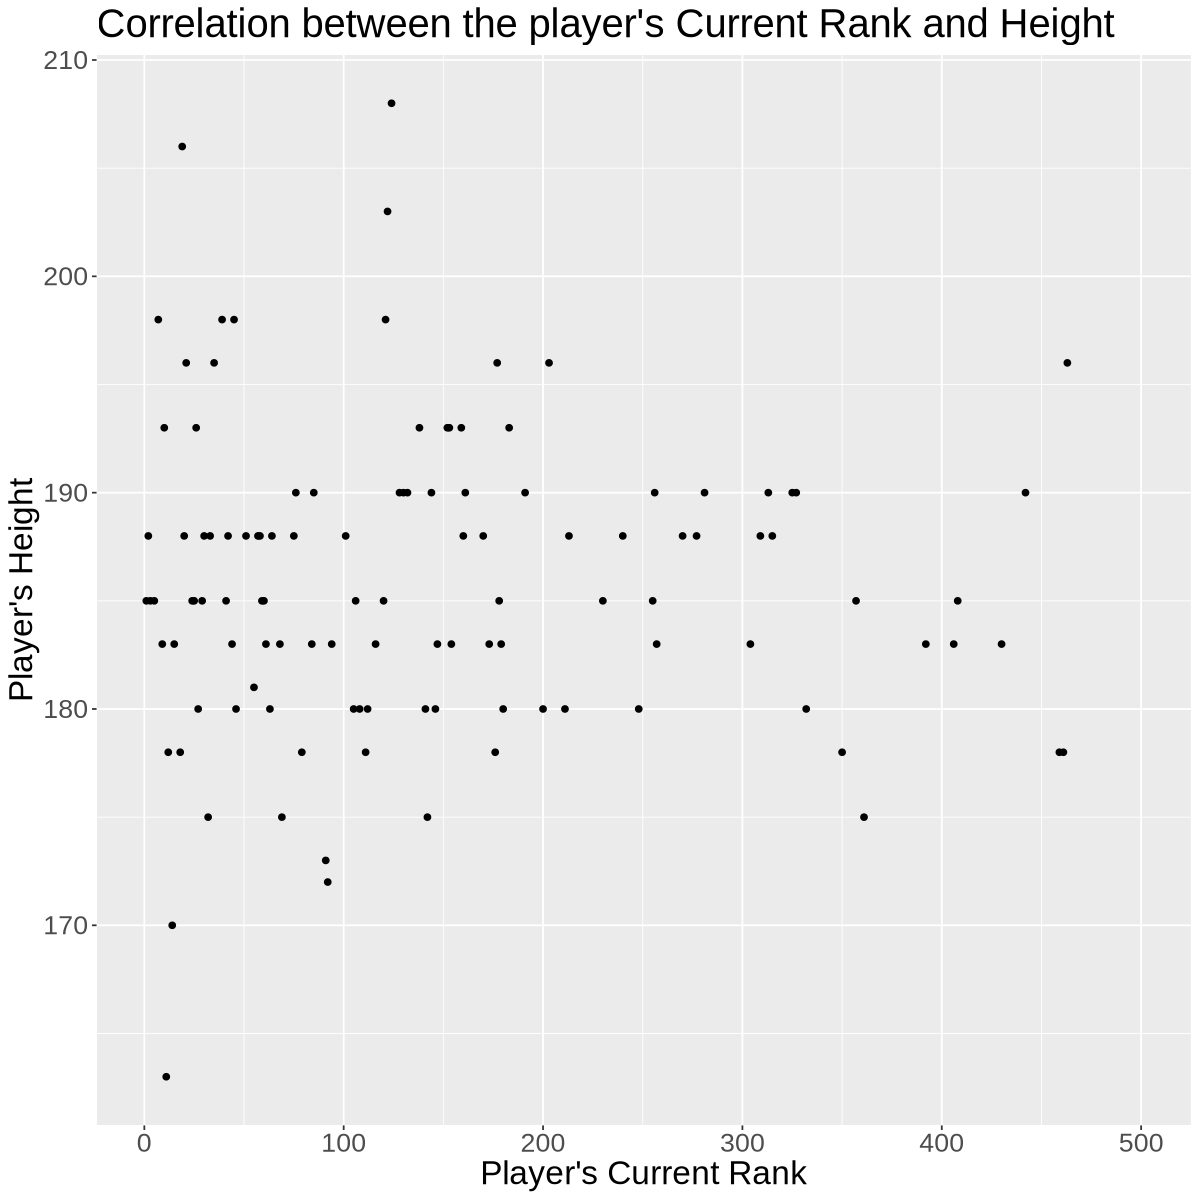

Warning message:
“Removed 5 rows containing missing values (`geom_point()`).”


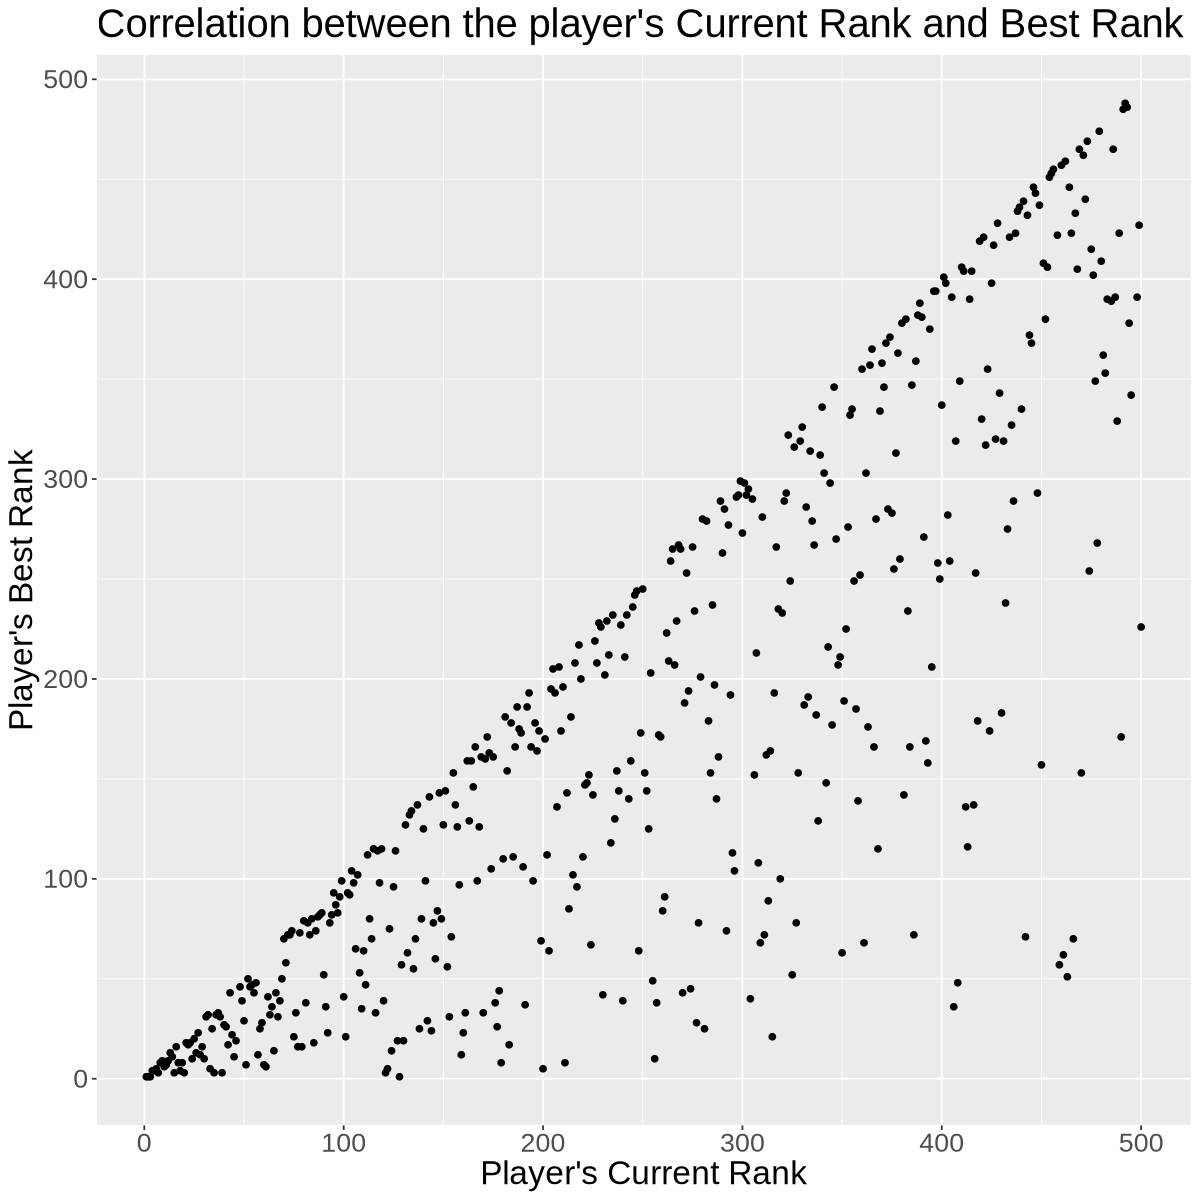

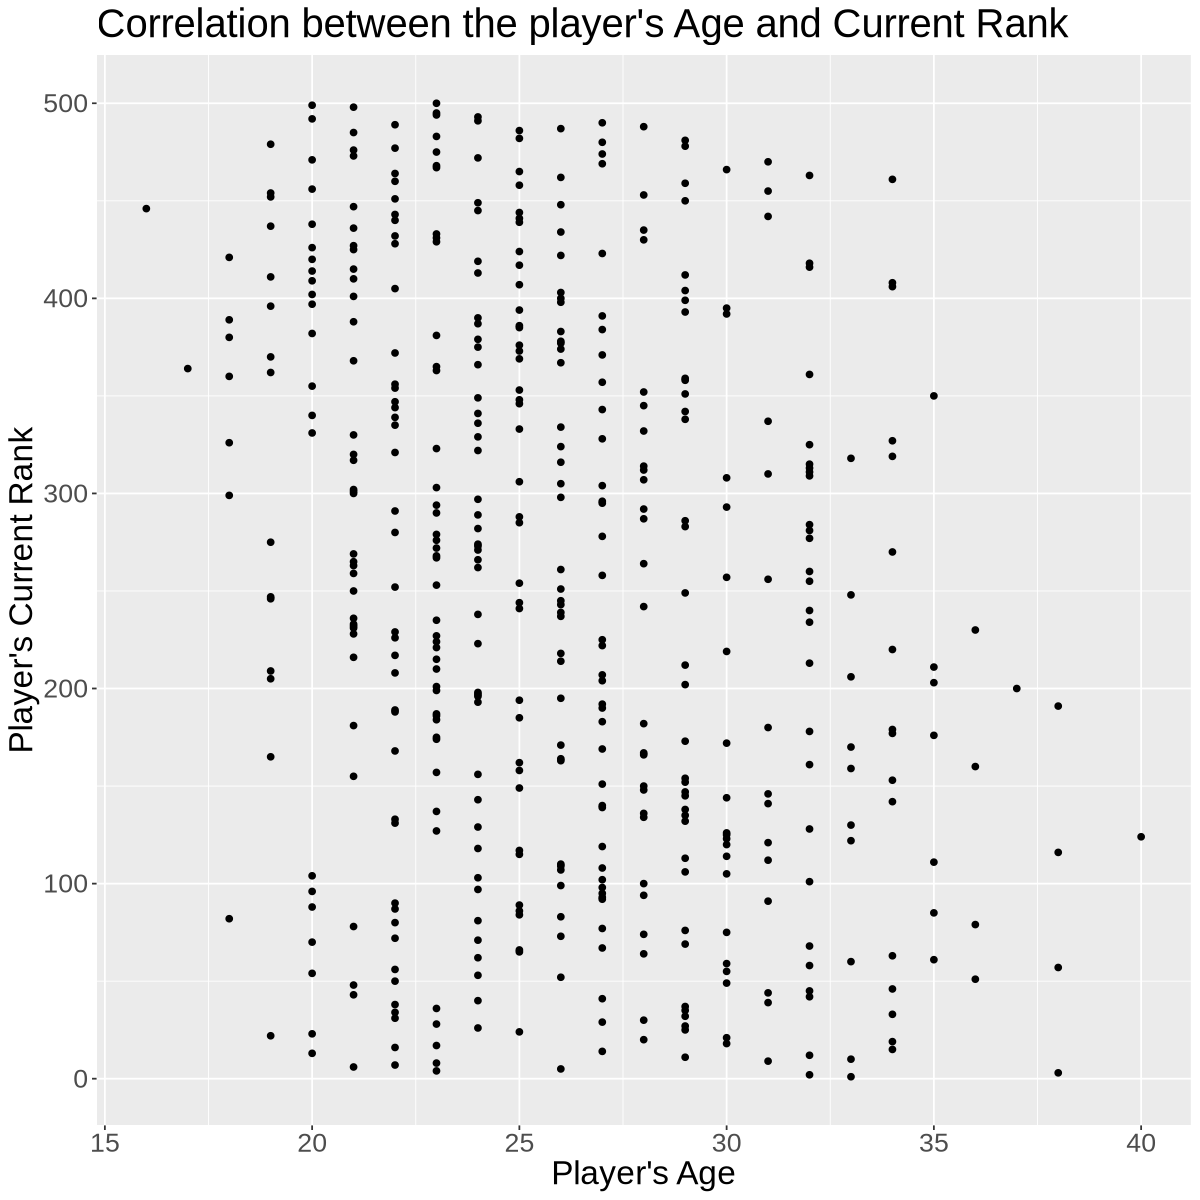

In [53]:
# Visualization for data
options(repr.plot.width= 10, repr.plot.height= 10)

# 1st Visualization on the correlation between Current Rank and Height
player_plot1 <- processed_player_data |>
            ggplot(aes(x= `CurrentRank`,y= `Height(cm)`)) +
            geom_point() +
            xlab("Player's Current Rank") +
            ylab("Player's Height") +
            ggtitle("Correlation between the player's Current Rank and Height") +
            theme(text = element_text(size=20))

# 2nd Visualization on the correlation between Current Rank and Best Rank
player_plot2 <- processed_player_data |>
            ggplot(aes(x= `CurrentRank`, y= `BestRank`)) +
            geom_point() +
            xlab("Player's Current Rank") +
            ylab("Player's Best Rank") +
            ggtitle("Correlation between the player's Current Rank and Best Rank") +
            theme(text = element_text(size=20))

# 3rd Visualization on the correlation between Age and Current Rank
player_plot3 <- processed_player_data |>
            ggplot(aes(x= Age, y= `CurrentRank`)) +
            geom_point() +
            xlab("Player's Age") +
            ylab("Player's Current Rank") +
            ggtitle("Correlation between the player's Age and Current Rank") +
            theme(text = element_text(size=20))

player_plot1
player_plot2
player_plot3

## Methods

### Relevant variables:
Predicted Variable: Best Rank
  
Predictors:
- Age
- Current Rank
- Height
- Year Turned pro
- Current ELO Rank
- Best ELO Rank
- Peak ELO Rating
- Weight
- Plays (Left-handed or Right-handed)
- Backhand (Two-Handed or One-Handed)
- Seasons Played
- Country


### Outlined procedure:
1. one
2. two
3. three
4. four
5. five

### Visualization:
At the moment, we have created three scatter plots to visualize the correlation between some predictors from the dataset: age, height, current rank, and best rank. From this, we can decide whether a variable should be used as a predictor for our project or not.  
Ultimately, we plan to graph a scatter plot + line plot to visualize our regression model. It will show how our regression model fares with the data.

## Expected Outcomes and Significance

### Expected findings:
We expect that a higher current rank, ELO ranks, and number of seasons will generally correlate with a higher best rank for that player.

### Relevancy of findings:
Our classification model could be used to predict how future ATP tennis players will rank. These findings could also reveal correlations between the predictor variables and the predicted variable, allowing tennis players to consider how these variables may have an influence on their performance. 

### Future studies:
More specific studies, that compare predictor variables and player rank in more depth, could provide more insight into possible correlations between the variables and player performance. Additionally, we focused on top players in the ATP, but future studies could be done on a wider population of tennis players, or on more casual players.

## References:

#### Data from:
- Ultimate tennis statistics. (n.d.). Ultimate Tennis Statistics.  
https://www.ultimatetennisstatistics.com/  


#### ATP information from:
- Wikipedia contributors. (2024, March 1). Association of Tennis Professionals - Wikipedia.     https://en.wikipedia.org/wiki/Association_of_Tennis_Professionals 

- Wikipedia contributors. (2024, March 6). ATP rankings. Wikipedia.  
https://en.wikipedia.org/wiki/ATP_rankings 

